# 决策树应用
## 实验分析
客户对于银行而言是重要的资产，对银行的收益以及市场占有率起着决定性作用。但是银行每年都要面对严重的客户流失问题，相较留住一个客户，获取一个新客户所需的成本往往是其数倍。因此分析出一个客户是否可能是潜在的易流失客户对于银行而言具有极大价值。
大多数银行对于客户流失问题关注度很高，但研究相对较少，目前只有少部分银行开始对真实案例进行建模分析。通过研究客户的历史行为来捕捉流失客户的特点，分析客户流失原因，从而可以在客户真正流失之前做出相应的营销干预，对客户进行挽留。
本例收集了国外银行的匿名化数据，包含了信用分数、存贷款情况、性别、年龄等一系列客户信息。

### 导入库

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [162]:
src_dir = r'./dataset/'

### 训练集
字段解析
RowNumber: 行号x
CustomerlD: 用户编号 
xSurname: 用户姓名 
xCreditScore: 信用分数
Geography:用户所在国家/地区
Gender: 用户性别
Age: 年龄
Tenure: 当了本银行多少年用户
Balance: 存贷款情况
NumofProducts: 使用产品数量
HasCrCard: 是否有本行信用卡
IsActiveMember: 是否活跃用户
EstimatedSalary: 估计收入
Exited: 是否已流失-标签数据

In [163]:
train_data = pd.read_csv(os.path.join(src_dir, 'train_data.csv'))

Python中Pandas库内的factorize函数可将相同的标称型映射为相同的数字，使非数值特征数值化。

In [164]:
def numeritative(data, cols):
    """
    对非数值化字段数值化
    :param data: 
    :param cols: 
    :return: 
    """
    for col in cols:
        data[col] = pd.factorize(data[col])[0]
    return data

地理位置Geography（France，Spain，Germany）、性别Gender（female，male）
这些非数值特征可能在分类中产生比较大的作用，因此为了使模型可以处理这些非数值特征，需要将这两个特征数值化

In [165]:
train_data = numeritative(train_data, ['Geography', 'Gender'])

### 数据离散化

In [166]:
def discretizate(data, cols_dict):
    """
    依据describe()的四分位划分，对连续型字段离散化0-low，1-middle，2-high)
    :param data: pd.DataFrame
    :param cols_dict: dict字典 (key, value)
    :return: 返回处理的data
    """
    for col, value in cols_dict.items():
        for i in data.index:
            if data.loc[i, col] < value['low']:
                data.loc[i, col] = 0
            elif value['low'] <= data.loc[i, col] < value['middle']:
                data.loc[i, col] = 1
            elif value['middle'] <= data.loc[i, col] < value['high']: \
                    data.loc[i, col] = 2
            else:

                data.loc[i, col] = 3  # high
    return data

In [167]:
describe = train_data.describe()
# pd.DataFrame.describe()返回值也是pd.DataFrame型，就不用再自行计算四分位
discretizate_dict = {
    'CreditScore': {'low': describe.loc['25%', 'CreditScore'],
                    'middle': describe.loc['50%', 'CreditScore'],
                    'high': describe.loc['75%', 'CreditScore']},
    'Age': {'low': describe.loc['25%', 'Age'],
            'middle': describe.loc['50%', 'Age'],
            'high': describe.loc['75%', 'Age']},
    'Balance': {'low': describe.loc['25%', 'Balance'],
                'middle': describe.loc['50%', 'Balance'],
                'high': describe.loc['75%', 'Balance']},
    'EstimatedSalary': {'low': describe.loc['25%', 'EstimatedSalary'],
                        'middle': describe.loc['50%', 'EstimatedSalary'],
                        'high': describe.loc['75%', 'EstimatedSalary']}}
train_data = discretizate(train_data, discretizate_dict)

# 前三后一 数据筛选
train_data = train_data[train_data.columns[3:-1]]

In [168]:
def select(data, target):
    """
    依据最简单的[欠采样]方法，对data采样
    :param data: pd.DataFrame型
    :param target: string型，data中表示目标分类的字段
    :return: 返回数值化处理后的data
    """
    # 类别1
    ones = sum(data[target])
    # 类别
    zeros = len(data[target]) - ones
    # 随机打乱
    data.sample(frac=1.0, replace=True)
    data = pd.concat([data.loc[data[target] == 0].iloc[:min(ones, zeros)],
                      data.loc[data[target] == 1].iloc[:min(ones, zeros)]])
    # 再次打乱返回
    return data.sample(frac=1.0)

In [169]:
train_data = select(train_data, 'Exited')
# 保存结果
train_data.to_csv(os.path.join(src_dir, 'train_data_final.csv'), index=False)

In [170]:
from sklearn.model_selection import train_test_split

In [171]:
data = pd.read_csv(os.path.join(src_dir, 'train_data_final.csv'))
# DecisionTreeClassifierg训练、评估过程需要MatrixLike | ArrayLike 类型
data_array = np.array(data)
features = data_array[:, :-1]
target = data_array[:, -1]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)
# 验证
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3259, 10) (815, 10) (3259,) (815,)


### 构建模型
对数据集进行预处理后，首先使用决策树进行银行客户流失预测的分析，将此流失预测的结果作为基准，之后在决策树模型的基础上，与多个常用分类算法调优的结果做比较。
决策树含义直观，容易解释。对于实际应用，决策树有其他算法难以比较的速度优势。因此，对于决策树而言，一方面能够有效地进行大规模数据的处理和学习，另一方面在测试/预测阶段满足实时或者更高的速度要求。

In [172]:
# 决策树回归模型
from sklearn.tree import DecisionTreeClassifier

DecisionTreeClassifier类参数
criterion: Literal['gini','entropy','log_loss']="gini",分裂节点的评价标准
min_samples_split: float]int = 2,一个节点分裂所需的最少样本数。
min_samples_leaf: float]int = 1,一个叶子分裂所需的最少样本数

In [173]:
# 设置决策树参数: 分裂节点的评价标准criterion="gini"
# P69-CART算法: 二分递归分割方法实现二叉树分支构建
model_1 = DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_split=100)

# 训练模型
model_1.fit(x_train, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_split=100)

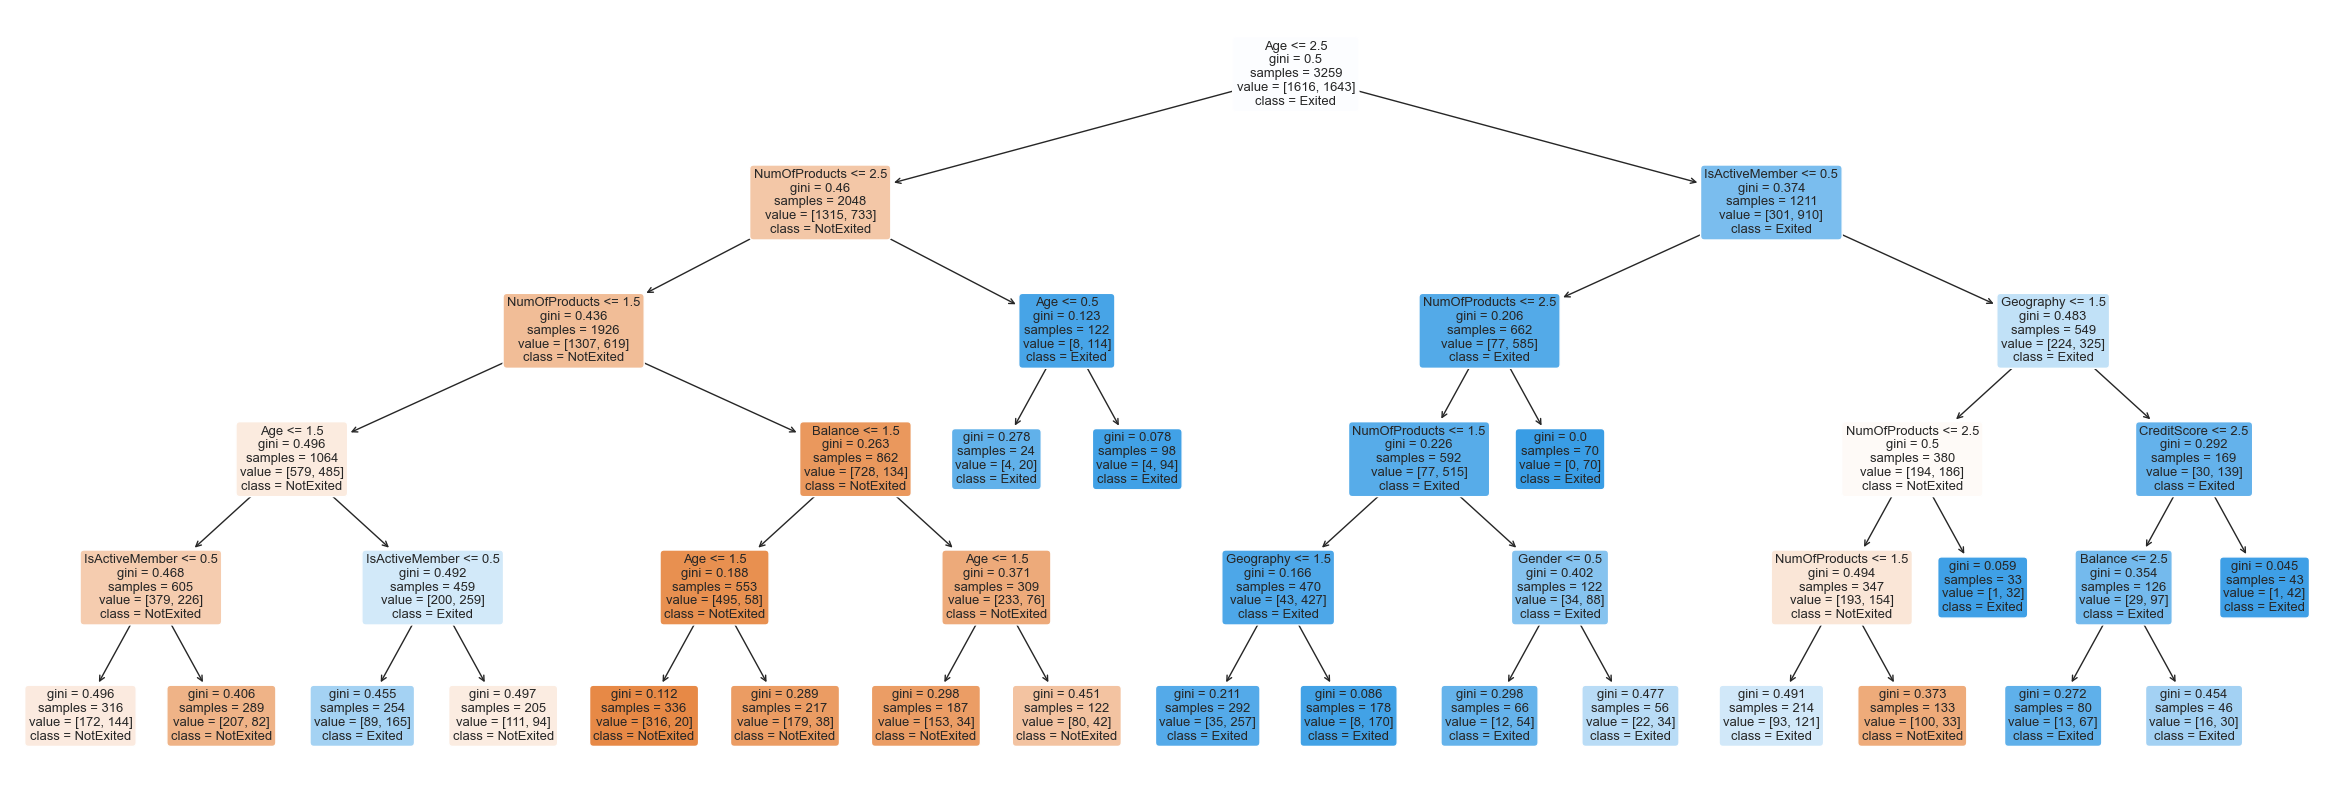

In [174]:
# 绘制决策树
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 10))
# 多加.tolist()成为列表参数给plot_tree函数接收
plot_tree(model_1, feature_names=data.columns[:-1].tolist(), class_names=['NotExited', 'Exited'], filled=True, rounded=True)

plt.show()

In [175]:
# DecisionTreeClassifier(max_depth=6, min_samples_split=200)

# 预测模型
y_pred = model_1.predict(x_test)

### 正确率
score函数

In [176]:
# 评估指标：分类正确率
score = model_1.score(x_test, y_test)
# scores列表 方便对比模型
scores = []
scores.append(score)

#### ROC曲线
ROC曲线指受试者工作特征曲线(Receiver Operating Characteristic Curve)
- 是反映敏感性和特异性连续变量的综合指标，用于表达敏感性和特异性的相互关系
- 它通过将连续变量设定出多个不同的临界值，从而计算出一系列敏感性和特异性
- 再以敏感性为纵坐标、1-特异性为横坐标绘制成曲线，曲线下面积越大，准确性就越高
- 在 ROC 曲线上，最靠近坐标图[左上方的点]为敏感性和特异性均较高的临界值

In [177]:
# 导入ROC曲线函数
from sklearn.metrics import roc_curve

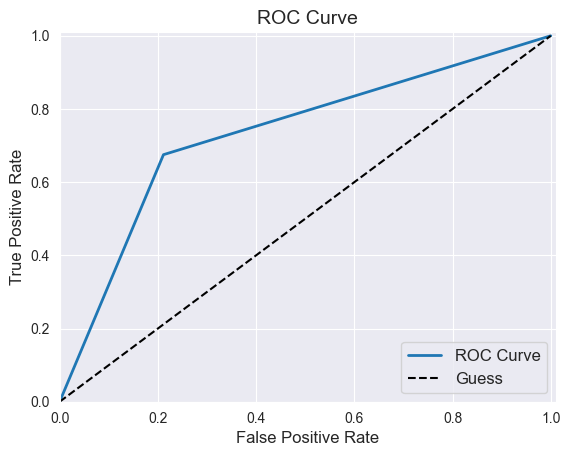

In [178]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

# figsize=(8，8)
plt.figure()
# 画出ROC曲线
plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')

plt.plot([0, 1], [0, 1], 'k--', label='Guess')
# 横坐标为假阳性率 (False Positive Rate，FPR)，FP是N个负
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

# 纵坐标为真阳性率 (True Positive Rate，TPR)
plt.ylim(0, 1.01)
plt.xlim(0, 1.01)

plt.title("ROC Curve", fontsize=14)
# 图例
plt.legend(loc=4, fontsize=12)
plt.savefig(os.path.join(src_dir, 'ROC Curve.png'))
# 显示作图结果
plt.show()

#### 混淆矩阵

In [179]:
from sklearn.metrics import confusion_matrix

In [180]:
# 混淆矩阵
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cms = []
cms.append(cm)

In [181]:
def draw(scores, cms):
    """
    绘制多个模型混淆矩阵
    :param scores: list(float)
    :param cms: list(np.array)
    :return: None
    """
    for i, (score, cm) in enumerate(zip(scores, cms)):
        plt.figure()  # figsize=(10，10)
        plt.matshow(cm, fignum=0, cmap=plt.cm.Oranges)
        # 颜色标签
        plt.colorbar()  
        # 数据标签
        for x in range(len(cm)):  
            for y in range(len(cm)):
                plt.annotate(cm[x, y], xy=(x, y), fontsize=12,
                             horizontalalignment='center',
                             verticalalignment='center')
                plt.xlabel('True Class', fontsize=12)
                plt.ylabel('Pred Class', fontsize=12)
        plt.title(f"Confusion Matrix (score={score:.2%})", fontsize=14)
        plt.savefig(os.path.join(src_dir, f'Confusion Matrix matshow model {i}.png'))
        plt.show()

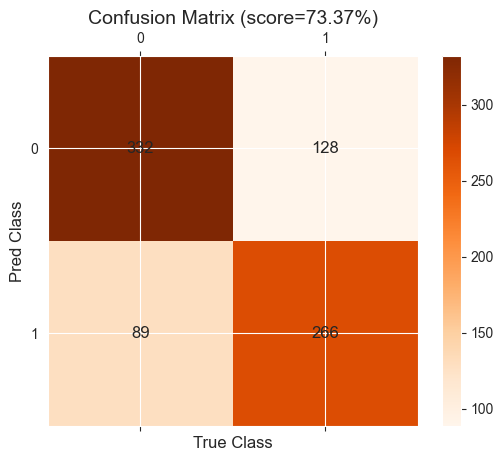

In [182]:
# 测试
draw(scores, cms)

In [183]:
import seaborn as sns

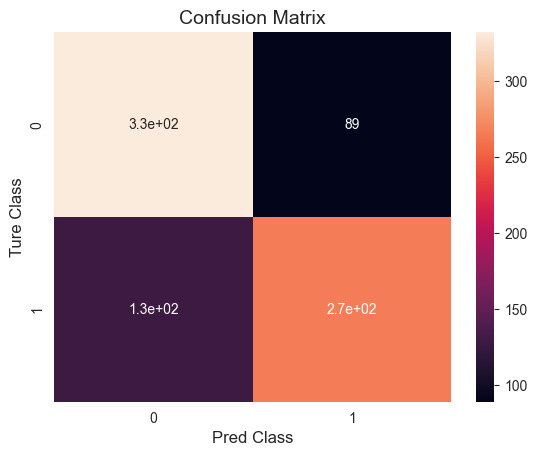

In [184]:
# 热力图
f, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Pred Class', fontsize=12)
ax.set_ylabel('Ture Class', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig(os.path.join(src_dir, f'Confusion Matrix_matshow_model_1.png'))
plt.show()

#### P-R曲线
Precision-Recall平衡，即精准率和召回率是相互制约的，如果想要精准率提高，召回率则会下降，如果要召回率提高，精准率则会下降，需要找到二者之间的一个平衡。

In [185]:
from sklearn.metrics import precision_recall_curve

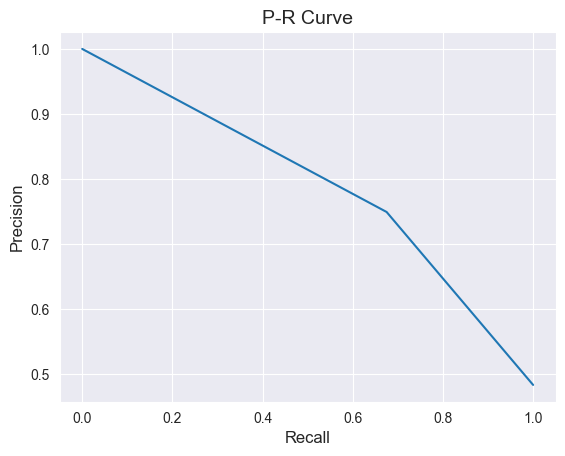

In [186]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('P-R Curve', fontsize=14)
plt.savefig(os.path.join(src_dir, 'P-R Curve.png'))
plt.show()

### 参数调优
- 模型参数
决策树算法在这个应用场景下还有改进空间，存在进一步提升算法性能的可能性，主要考虑通过增强决策树的最大深度或者增加节点分裂所需最小样本数量来提升算法的性能。
a)	max_depth：默认为不输入。如果不输入，决策树在建立子树的时候不会限制子树的深度。一般来说，数据少或特征少的时候可以不考虑这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。若深度过小，决策树可能过于简单而发生欠拟合情况，若深度过大，决策树则越容易过拟合。
b)	min_samples_split：表示一个节点分裂所需的最少样本数，若样本数小于该值，则不再继续分支。
- 超参数调优
k折交叉验证（Cross Validation）是检验模型的重要方法，可以进一步提升模型的准确度。k值需要选择一个合理的值（经验值取10），通常k越大，训练集越大，会导致方差越大，训练花费的时间越长。


In [187]:
# k折交叉验证
from sklearn.model_selection import StratifiedKFold

In [204]:
def kfold_cv(ks):
    """
    K折交叉验证
    :param ks: list(int), arg is k
    :return: None
    """

    def draw(x, y, k, avg, max, min):
        """
        绘制折现图
        :param x: list(int)
        :param y: list(float)
        :param k: int
        :param avg: 
        :param max: 
        :param min: 
        :return: None
        """
        plt.plot(x, y)
        plt.ylim(0.5, 1.0)
        plt.xlabel('k Rounds')
        plt.ylabel('True Rate')
        plt.title(
            f'KFold Cross Validation\n(k={k},tol={int(x_test.shape[0] / k)}, ' + f'avg={avg:.2%},max={max:.2%},min={min:.2%})')
        plt.savefig(os.path.join(src_dir, f'KFold Cross Validation_{k}.png'))
        plt.show()

    # 处理模型
    for k in ks:
        # KFold
        skfold = StratifiedKFold(n_splits=k, shuffle=False)
        # 模型参数调优
        model = DecisionTreeClassifier(
            criterion='gini', max_depth=8, min_samples_split=200
        )
        
        y = []
        m = []
        for train_index, test_index in skfold.split(features, target):
            skfold_x_train = features[train_index]
            skfold_y_train = target[train_index]
            model.fit(skfold_x_train, skfold_y_train)
            skfold_x_test = features[test_index]
            skfold_y_test = target[test_index]
            
            y.append(model.score(skfold_x_test, skfold_y_test))
            m.append(confusion_matrix(skfold_y_test,
                                      model.predict(skfold_x_test), labels=[0, 1]))
        
        avg, max, min = np.mean(y), np.max(y), np.min(y)
        draw(range(1, k + 1), y, k, avg, max, min)
        # 添加到模型对比（横向纵向对比）
        scores.append(avg)
        tp = []
        fn = []
        fp = []
        tn = []
        for tmp in m:
            tp.append(tmp[0][0])
            fn.append(tmp[0][1])
            fp.append(tmp[1][0])
            tn.append(tmp[1][1])
        cm = np.array([[int(np.mean(tp)), int(np.mean(fn))],
                       [int(np.mean(fp)), int(np.mean(tn))]])
        cms.append(cm)

### 调优分析
分析6/8层、100/200分裂节点的决策树与5/10/15/20折交叉验证的建模效果
- 考虑max_depth影响；
- 考虑min_samples_split影响；
- 考虑K折影响；

### 对照模型
在面对分类问题时，常用的还有SVM、神经网络等算法，这些算法在面对不同特点、规模和领域的数据时各有所长。为了确定决策树是最适合的算法，分别对以上算法的预测准确性做一次全面的评估。

#### SVM支持向量机

In [189]:
from sklearn import svm

In [190]:
svc = svm.SVC()
svc.fit(x_train, y_train)

SVC()

In [191]:
scores.append(svc.score(x_test, y_test))
cms.append(confusion_matrix(y_test, svc.predict(x_test)))

#### 神经网络分类模型

In [192]:
from sklearn.neural_network import MLPClassifier

In [193]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 11), 
                    random_state=1)
mlp.fit(x_train, y_train)

F:\Anaconda3\envs\machine_learning_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(10, 11), random_state=1,
              solver='lbfgs')

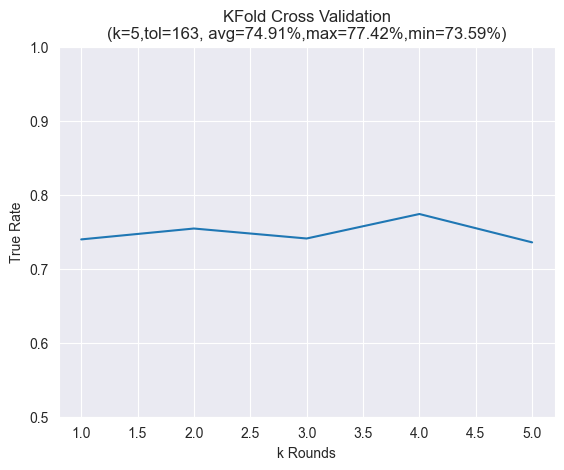

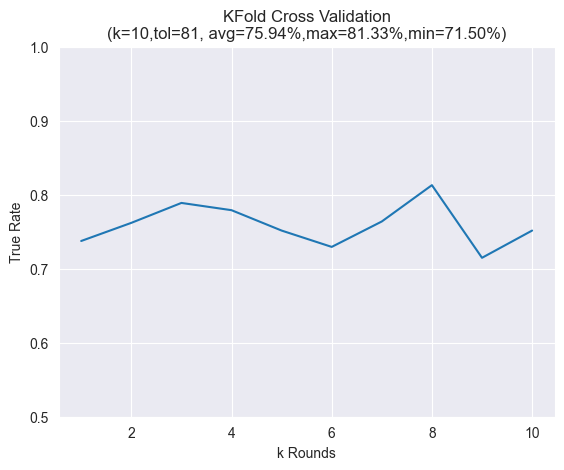

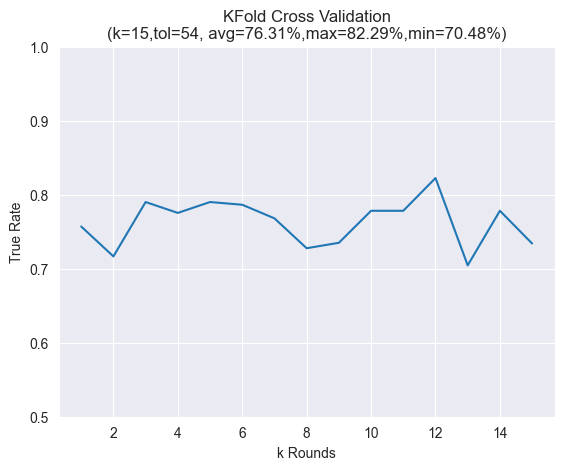

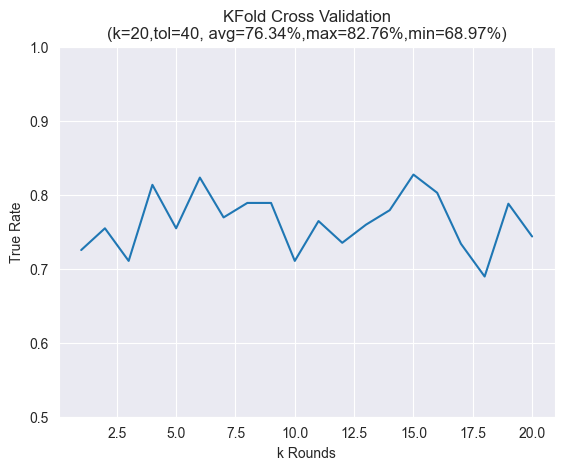

In [205]:
ks = [5, 10, 15, 20]
kfold_cv(ks)

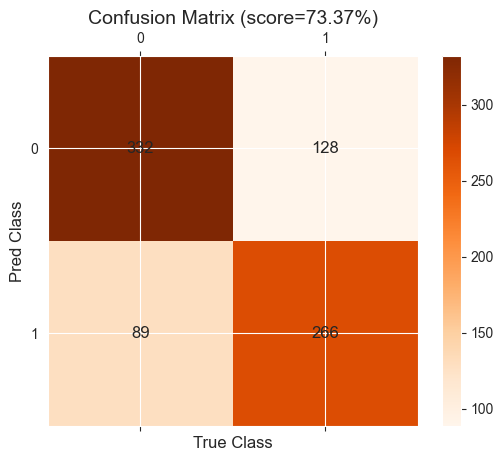

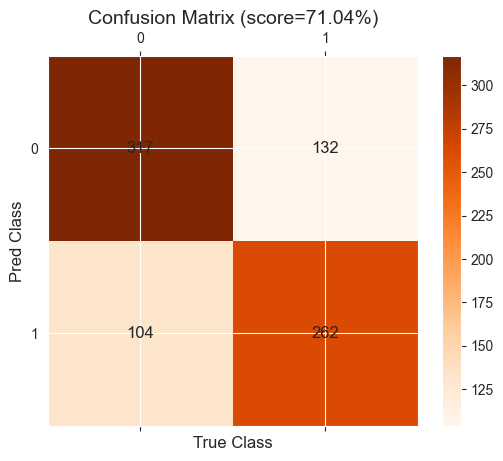

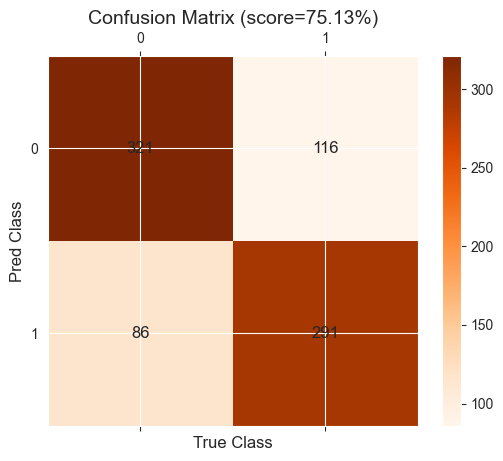

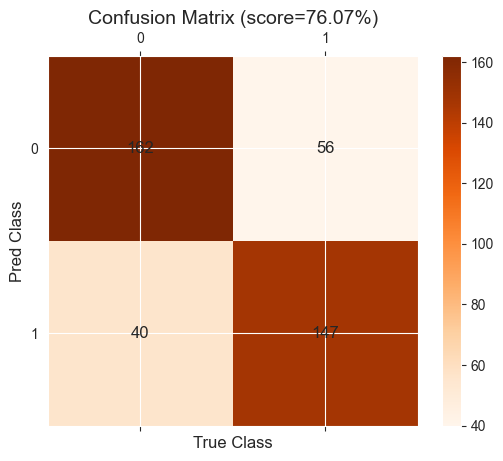

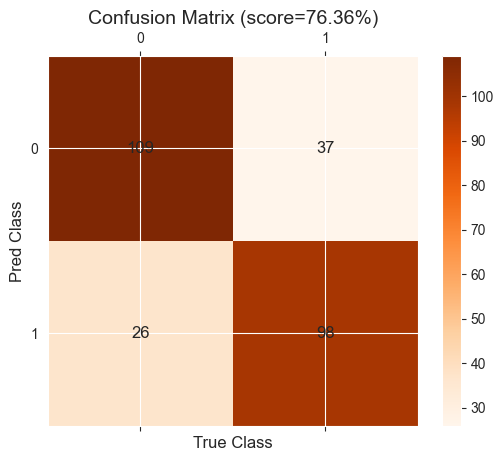

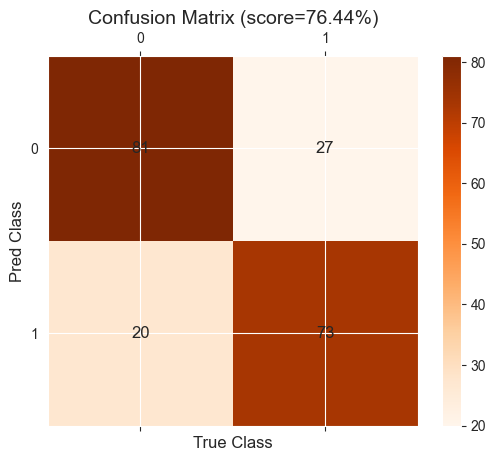

In [195]:
draw(scores, cms)